In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from scipy import stats
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"
chunk_dict={"time":50,"lat":100,"lon":100}


In [3]:
m="NICAM"

In [4]:
cli = xr.open_dataset(ap.get_file(m,"cli", region=region+"_3D"), 
                              chunks=chunk_dict).cli[:,:,:284//2,:284//2]
cli

<xarray.DataArray 'cli' (time: 240, lev: 78, lat: 142, lon: 142)>
dask.array<getitem, shape=(240, 78, 142, 142), dtype=float32, chunksize=(50, 78, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-29
  * lon      (lon) float64 143.0 143.1 143.1 143.1 ... 147.9 147.9 148.0 148.0
  * lat      (lat) float64 -4.975 -4.939 -4.904 ... -0.0879 -0.0527 -0.0176
  * lev      (lev) float64 33.15 103.0 180.1 ... 4.376e+04 4.687e+04 5.031e+04
Attributes:
    standard_name:  mass_fraction_of_cloud_ice_in_air
    long_name:      cloud ice mixing ratio
    units:          kg kg-1
    origin:         ms_qi

In [5]:
iwp = xr.open_dataset(ap.get_file(m,"clivi", region=region), 
                              chunks=chunk_dict).clivi.sel(time=cli.time, method="nearest")[:,:284//2,:284//2]
iwp

<xarray.DataArray 'clivi' (time: 240, lat: 142, lon: 142)>
dask.array<getitem, shape=(240, 142, 142), dtype=float32, chunksize=(5, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28T23:45:00
  * lon      (lon) float64 143.0 143.1 143.1 143.1 ... 147.9 147.9 148.0 148.0
  * lat      (lat) float64 -4.975 -4.939 -4.904 ... -0.0879 -0.0527 -0.0176
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_ice
    long_name:      column integrated solid water (ice water path)
    units:          kg m-2
    origin:         sa_cldi

In [6]:
z = cli.lev

In [7]:
m, iwp.shape, cli.shape, z.shape

('NICAM', (240, 142, 142), (240, 78, 142, 142), (78,))

In [8]:
iwp_full = np.repeat(iwp.values[:,np.newaxis,:,:], 78, axis=1)
z_full = np.repeat(np.repeat(np.repeat(z.values[np.newaxis, :, np.newaxis, np.newaxis], 284//2, axis=3), 284//2, axis=2), 240, axis=0)
iwp_full.shape, z_full.shape

[########################################] | 100% Completed |  2.1s


((240, 78, 142, 142), (240, 78, 142, 142))

In [16]:
hist, x_edges, y_edges, binnum = stats.binned_statistic_2d(iwp_full.flatten(), z_full.flatten(), cli.values.flatten(), 
                          statistic="count", bins=[np.logspace(-7,2,20),np.linspace(0,20000,12)])

[########################################] | 100% Completed |  3.2s


In [17]:
hist.shape

(19, 11)

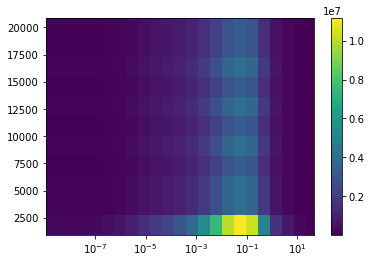

In [18]:
plt.pcolormesh(x_edges[:-1], y_edges[1:], hist.T)
plt.xscale('log')
plt.colorbar()
plt.show()